# Imports

In [1]:
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, ReLU, BatchNormalization, Flatten, Dense, Dropout, ReLU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import pickle
from glob import glob
import cv2
import random
from keras.callbacks import ModelCheckpoint
import math

Using TensorFlow backend.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
tf.__version__

'2.2.0'

In [4]:
keras.__version__

'2.3.1'

### Functions

In [5]:
def split_nd_coordinates_array(coordinates_array, n): 
    m = 0
    r = n
    frame_coordinates = []
    for j in range(0,int(len(coordinates_array)/n)):
        frame_coordinates.append(coordinates_array[m:r])
        m = r
        r = r+n
    return(np.array(frame_coordinates))

### Variables

In [6]:
synth_columns_df_2D_interest = ['right_shoulder_2D','right_shoulder_2D.1',
                          'right_elbow_2D','right_elbow_2D.1',
                          'right_wrist_2D', 'right_wrist_2D.1',          
                          'left_shoulder_2D','left_shoulder_2D.1',  
                          'left_elbow_2D','left_elbow_2D.1',
                          'left_wrist_2D','left_wrist_2D.1']

synth_columns_df_3D_interest = ['right_shoulder','right_shoulder.1','right_shoulder.2',
                          'right_elbow', 'right_elbow.1','right_elbow.2',
                          'right_wrist','right_wrist.1','right_wrist.2',
                          'left_shoulder','left_shoulder.1','left_shoulder.2',
                          'left_elbow', 'left_elbow.1', 'left_elbow.2',
                          'left_wrist','left_wrist.1','left_wrist.2']


columns_df_2D_interest = ['RightShoulder_2D','RightShoulder_2D.1',
                          'RightElbow_2D', 'RightElbow_2D.1',
                          'RightHand_2D','RightHand_2D.1',
                          'LeftShoulder_2D','LeftShoulder_2D.1',
                          'LeftElbow_2D', 'LeftElbow_2D.1', 
                          'LeftHand_2D','LeftHand_2D.1']

columns_df_3D_interest = ['RightShoulder','RightShoulder.1','RightShoulder.2',
                          'RightElbow', 'RightElbow.1','RightElbow.2',
                          'RightHand','RightHand.1','RightHand.2',
                          'LeftShoulder','LeftShoulder.1','LeftShoulder.2',
                          'LeftElbow', 'LeftElbow.1', 'LeftElbow.2',
                          'LeftHand','LeftHand.1','LeftHand.2']

mapping_numbers_variables = {0:'right_shoulder',
                             1:'right_elbow',
                             2:'right_wrist',
                             3:'left_shoulder',
                             4:'left_elbow',
                             5:'left_wrist'}

keypoints_number = 6
                        
total_num_2Dcoordinates = len(mapping_numbers_variables)*2
total_num_3Dcoordinates = len(mapping_numbers_variables)*3

### Load synthetic dataset

In [7]:
df_synth_2D = pd.read_csv('../../../datasets/RGSClinic/No-Gravity/Augmented_Dataset_Synthetically.csv')[synth_columns_df_2D_interest]
df_synth_3D = pd.read_csv('../../../datasets/RGSClinic/No-Gravity/Augmented_Dataset_Synthetically.csv')[synth_columns_df_3D_interest]
print(df_synth_2D.shape)
print(df_synth_3D.shape)

(3000, 12)
(3000, 18)


In [8]:
df_synth_2D.head(5)

,right_shoulder_2D,right_shoulder_2D.1,right_elbow_2D,right_elbow_2D.1,right_wrist_2D,right_wrist_2D.1,left_shoulder_2D,left_shoulder_2D.1,left_elbow_2D,left_elbow_2D.1,left_wrist_2D,left_wrist_2D.1
0,829.668,620.026,733.575,428.649,570.274,105.571,1101.904,620.796,1127.765,412.465,1172.218,66.593
1,826.891,623.546,812.388,435.529,789.779,123.665,1097.584,622.713,1075.394,418.671,1039.059,95.303
2,817.019,611.056,777.653,392.228,707.068,24.798,1088.072,617.441,1119.901,412.891,1178.470,64.722
3,845.763,625.581,753.370,426.539,606.793,113.032,1107.994,619.725,1105.795,398.670,1105.028,51.921
4,844.894,613.848,739.948,419.766,563.428,100.494,1114.148,606.396,1169.481,369.158,1186.391,39.003


In [9]:
# Transform synthetic Y as it is inversed. 
height,width = (1080,1920)

#Filtro nombres columnas y 
y_cols_gt = []

for value in df_synth_2D:
    if len(value.split('.')) == 2:
        y_cols_gt.append(value)

#Aplico conversion a sistema opencv//Mediapipe
df_gt_y = df_synth_2D[y_cols_gt]
df_gt_y = height - df_gt_y  

#Replace de las y en df_gt
df_synth_2D[y_cols_gt] = df_gt_y
df_synth_2D.head(5)

,right_shoulder_2D,right_shoulder_2D.1,right_elbow_2D,right_elbow_2D.1,right_wrist_2D,right_wrist_2D.1,left_shoulder_2D,left_shoulder_2D.1,left_elbow_2D,left_elbow_2D.1,left_wrist_2D,left_wrist_2D.1
0,829.668,459.974,733.575,651.351,570.274,974.429,1101.904,459.204,1127.765,667.535,1172.218,1013.407
1,826.891,456.454,812.388,644.471,789.779,956.335,1097.584,457.287,1075.394,661.329,1039.059,984.697
2,817.019,468.944,777.653,687.772,707.068,1055.202,1088.072,462.559,1119.901,667.109,1178.470,1015.278
3,845.763,454.419,753.370,653.461,606.793,966.968,1107.994,460.275,1105.795,681.330,1105.028,1028.079
4,844.894,466.152,739.948,660.234,563.428,979.506,1114.148,473.604,1169.481,710.842,1186.391,1040.997


### Load MoCap data

In [10]:
df_mocap_2D = pd.read_csv('../../../datasets/RGSClinic/No-Gravity/Dataset_MoCap_RGSclinic_KinectCamera.csv')[columns_df_2D_interest]
df_mocap_3D  = pd.read_csv('../../../datasets/RGSClinic/No-Gravity/Dataset_MoCap_RGSclinic_KinectCamera.csv')[columns_df_3D_interest]

print(df_mocap_2D.shape)
print(df_mocap_2D.shape)

(32948, 12)
(32948, 12)


### 2D and 3D data augmentation

In [11]:
#2D augmentation via flipping x axis
height,width = (1080,1920)

flipped_list_2D = []
for i in range(0,len(df_mocap_2D)):
    frame_keypoint_coordinates = split_nd_coordinates_array(np.array(df_mocap_2D.iloc[i]),2)
    flipped_frame_coordinates_x = width - frame_keypoint_coordinates[:,0]
    flipped_array = np.zeros([6,2])
    flipped_array[:,0] = flipped_frame_coordinates_x
    flipped_array[:,1] = frame_keypoint_coordinates[:,1]
    
    #Transforming it to vector(12,)
    flipped_array = flipped_array.reshape(-1)
    flipped_list_2D.append(flipped_array)

#To map the dataframe columns into its flipped corresponding keypoint name
flipped_columns_names_2D = [
    'LeftShoulder_2D','LeftShoulder_2D.1',
    'LeftElbow_2D','LeftElbow_2D.1',
    'LeftHand_2D','LeftHand_2D.1',
    'RightShoulder_2D','RightShoulder_2D.1',
    'RightElbow_2D','RightElbow_2D.1',
    'RightHand_2D','RightHand_2D.1']
                        
flipped_2D_df = pd.DataFrame(flipped_list_2D).rename(columns=dict(enumerate(flipped_columns_names_2D)))

#Sorting it in the same order as the original dataframe to append it
flipped_2D_df = flipped_2D_df[['RightShoulder_2D','RightShoulder_2D.1','RightElbow_2D','RightElbow_2D.1','RightHand_2D','RightHand_2D.1', 'LeftShoulder_2D','LeftShoulder_2D.1','LeftElbow_2D','LeftElbow_2D.1','LeftHand_2D','LeftHand_2D.1']]
df_mocap_2D = df_mocap_2D.append(flipped_2D_df).reset_index().drop(columns=['index'])


#3D data augmentation via flipping x axis

flipped_list_3D = []
for i in range(0,len(df_mocap_3D)):
    frame_3d_keypoint_coordinates_x = np.array(split_nd_coordinates_array(np.array(df_mocap_3D.iloc[i]),3))

    
    flipped_3d_array = np.zeros([6,3])
    flipped_3d_array[:,0] = -frame_3d_keypoint_coordinates_x[:,0]
    flipped_3d_array[:,1] = frame_3d_keypoint_coordinates_x[:,1]
    flipped_3d_array[:,2] = frame_3d_keypoint_coordinates_x[:,2]
    
    flipped_3d_array = flipped_3d_array.reshape(-1)
    flipped_list_3D.append(flipped_3d_array)

flipped_columns_names_3D = [
    'LeftShoulder', 'LeftShoulder.1', 'LeftShoulder.2',
    'LeftElbow', 'LeftElbow.1', 'LeftElbow.2', 
    'LeftHand', 'LeftHand.1','LeftHand.2',
    'RightShoulder', 'RightShoulder.1', 'RightShoulder.2', 
    'RightElbow','RightElbow.1', 'RightElbow.2', 
    'RightHand', 'RightHand.1','RightHand.2', ]

flipped_3D_df = pd.DataFrame(flipped_list_3D).rename(columns=dict(enumerate(flipped_columns_names_3D)))
flipped_3D_df = flipped_3D_df[['RightShoulder', 'RightShoulder.1', 'RightShoulder.2', 'RightElbow',
       'RightElbow.1', 'RightElbow.2', 'RightHand', 'RightHand.1',
       'RightHand.2', 'LeftShoulder', 'LeftShoulder.1', 'LeftShoulder.2',
       'LeftElbow', 'LeftElbow.1', 'LeftElbow.2', 'LeftHand', 'LeftHand.1',
       'LeftHand.2']]
df_mocap_3D = df_mocap_3D.append(flipped_3D_df).reset_index().drop(columns=['index'])

In [12]:
print(df_mocap_2D.shape)
df_mocap_2D.head(5)

(65896, 12)


,RightShoulder_2D,RightShoulder_2D.1,RightElbow_2D,RightElbow_2D.1,RightHand_2D,RightHand_2D.1,LeftShoulder_2D,LeftShoulder_2D.1,LeftElbow_2D,LeftElbow_2D.1,LeftHand_2D,LeftHand_2D.1
0,797.452,315.561,689.283,415.473,674.329,507.777,1059.528,292.694,1162.435,403.372,1168.681,509.249
1,799.223,315.503,689.749,418.406,673.601,507.777,1060.137,293.373,1160.638,408.702,1167.333,509.038
2,800.822,314.811,690.259,419.965,673.805,507.551,1060.686,295.488,1157.473,414.440,1166.137,509.049
3,803.037,314.930,691.388,421.519,674.083,508.017,1061.131,298.209,1155.107,421.575,1163.204,508.152
4,805.085,314.418,691.507,422.739,673.805,507.551,1061.705,301.029,1152.535,430.383,1157.708,507.696


In [13]:
print(df_mocap_3D.shape)
df_mocap_3D.head(5)

(65896, 18)


,RightShoulder,RightShoulder.1,RightShoulder.2,RightElbow,RightElbow.1,RightElbow.2,RightHand,RightHand.1,RightHand.2,LeftShoulder,LeftShoulder.1,LeftShoulder.2,LeftElbow,LeftElbow.1,LeftElbow.2,LeftHand,LeftHand.1,LeftHand.2
0,-0.227,0.313,1.341,-0.433,0.199,1.535,-0.392,0.044,1.317,0.139,0.345,1.341,0.326,0.220,1.546,0.292,0.043,1.343
1,-0.226,0.316,1.349,-0.433,0.195,1.538,-0.393,0.044,1.317,0.141,0.347,1.352,0.325,0.213,1.555,0.291,0.043,1.347
2,-0.225,0.318,1.357,-0.433,0.193,1.541,-0.393,0.045,1.318,0.143,0.347,1.363,0.322,0.205,1.565,0.290,0.044,1.351
3,-0.223,0.320,1.364,-0.432,0.191,1.544,-0.393,0.044,1.320,0.145,0.347,1.376,0.320,0.194,1.575,0.286,0.045,1.351
4,-0.221,0.322,1.370,-0.432,0.189,1.545,-0.393,0.045,1.318,0.147,0.345,1.388,0.317,0.180,1.581,0.278,0.045,1.350


### Merge both datasets into one.
Synthetic data has not been mirrored as it is mirrored during its creation and it is a 5% of the mocap_dataset augmented

In [14]:
df_synth_2D = df_synth_2D.rename(columns=dict(zip(synth_columns_df_2D_interest, columns_df_2D_interest)))
df_synth_3D = df_synth_3D.rename(columns=dict(zip(synth_columns_df_3D_interest, columns_df_3D_interest)))

df_mocap_2D = df_mocap_2D.append(df_synth_2D).reset_index().drop(columns=['index'])
df_mocap_3D = df_mocap_3D.append(df_synth_3D).reset_index().drop(columns=['index'])
print(df_mocap_2D.shape)
print(df_mocap_3D.shape)

(68896, 12)
(68896, 18)


### Noise addition for data augmentation

In [15]:
def split_2_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 2
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/2)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+2
        output.append(frame_coordinates)
    return(output)

In [16]:
df_2D_original_splitted = pd.DataFrame(split_2_coordinates(np.array(df_mocap_2D)))
df_2D_noise1 = []
for i in range(0,df_2D_original_splitted.shape[0]):
    row_keypoint_numbers = []
    for j in range(0,df_2D_original_splitted.shape[1]):
        
        circle_r = 25 #Maximum radius
        
        circle_x = df_2D_original_splitted.iloc[i][j][0]
        circle_y = df_2D_original_splitted.iloc[i][j][1]
        
        alpha = 2 * math.pi * random.random()
        # random radius
        r = circle_r * math.sqrt(random.random())
        
        # calculating coordinates
        x = r * math.cos(alpha) + circle_x
        x = round(x,2)
        
        y = r * math.sin(alpha) + circle_y
        y = round(y,2)
        
        row_keypoint_numbers.append(x)
        row_keypoint_numbers.append(y)
    df_2D_noise1.append(row_keypoint_numbers)
    
    
df_2D_noise1 = pd.DataFrame(df_2D_noise1)
    
df_mocap_2D = df_2D_noise1
df_mocap_2D.head(5)
print(df_mocap_2D.shape)

(68896, 12)


### Data normalization

In [17]:
scaler_2d = StandardScaler()
scaler_3d = StandardScaler()
df_mocap_2D = pd.DataFrame(scaler_2d.fit_transform(np.array(df_mocap_2D)), columns = columns_df_2D_interest)
df_mocap_3D = pd.DataFrame(scaler_3d.fit_transform(np.array(df_mocap_3D)), columns = columns_df_3D_interest)

### Train test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df_mocap_2D), np.array(df_mocap_3D), test_size=0.1, random_state=27, shuffle = None)
print(X_train.shape)
print(y_train.shape)

(62006, 12)
(62006, 18)


### Building model

In [19]:
#Martinez et. al architecture approach

def build_model():
    
    #Recommended by Martinez --> kernel_initializer = 'HeNormal'
    inputs = keras.Input(shape=(total_num_2Dcoordinates,), name='2d_vects')
    l1 = layers.Dense(1024, kernel_initializer='normal')(inputs)
    block_1_output = layers.Dense(1024, kernel_initializer='normal')(l1)
    x = layers.BatchNormalization()(block_1_output)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, kernel_initializer='normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    block_2_output = layers.add([x,block_1_output])
    
    block_3_output = layers.Dense(1024,kernel_initializer='normal')(block_2_output)
    y = layers.BatchNormalization()(block_3_output)
    y = layers.ReLU()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(1024, kernel_initializer='normal')(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Dropout(0.5)(y)
    block_4_output = layers.add([y, block_2_output])
    l2 = layers.Dense(1024, kernel_initializer='normal')(block_4_output)
    outputs = layers.Dense((total_num_3Dcoordinates))(l2)

    

    model = keras.Model(inputs, outputs)

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                 loss = 'mean_squared_error',
                 metrics=['mse'])
    return model

# model = build_model()
# model.summary()

In [20]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MPG]')
    plt.ylim([0, 2])
    plt.plot(hist['epoch'], hist['mse'], alpha = 0.7,
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.title('Learning curves')
    plt.legend()
    plt.show()

In [21]:
def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

## FNN training & eval

In [22]:
checkpoint = ModelCheckpoint("../models/Non_Gravity/noise_lvl1_with_synth_augmented/model.h5", monitor='loss', verbose=1,save_best_only=True, mode='auto', period=50)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

#Defining the maximum number of epochs that can be performed.
EPOCHS = 300
model = build_model()


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
#Verbose= 0 --> Silent
#history = model.fit(X_train, y_train, epochs=EPOCHS,validation_split = 0.15, batch_size = 64, verbose=1, callbacks=[early_stop])
history = model.fit(X_train, y_train, epochs=EPOCHS,validation_split = 0.15, batch_size = 64, verbose=1, callbacks=[checkpoint])

Train on 52705 samples, validate on 9301 samples
Epoch 1/300
52705/52705 [==============================] - 7s 129us/step - loss: 0.5767 - mse: 0.5767 - val_loss: 0.0412 - val_mse: 0.0412
Epoch 2/300
52705/52705 [==============================] - 6s 114us/step - loss: 0.0754 - mse: 0.0754 - val_loss: 0.0448 - val_mse: 0.0448
Epoch 3/300
52705/52705 [==============================] - 6s 113us/step - loss: 0.0478 - mse: 0.0478 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 4/300
52705/52705 [==============================] - 6s 116us/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0175 - val_mse: 0.0175 4s - los - ETA: 3s - loss: 
Epoch 5/300
52705/52705 [==============================] - 6s 116us/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 6/300
52705/52705 [==============================] - 6s 113us/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 7/300
52705/52705 [==============================] - 6s 115us/step - loss: 0.0209 -

52705/52705 [==============================] - 6s 114us/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 58/300
52705/52705 [==============================] - 6s 115us/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0055 - val_mse: 0.00553s
Epoch 59/300
52705/52705 [==============================] - 6s 114us/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 60/300
52705/52705 [==============================] - 6s 116us/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 61/300
52705/52705 [==============================] - 6s 113us/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 62/300
52705/52705 [==============================] - 6s 113us/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 63/300
52705/52705 [==============================] - 6s 115us/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 64/300
52705/52705 [=====

52705/52705 [==============================] - 6s 116us/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 115/300
52705/52705 [==============================] - 6s 112us/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 116/300
52705/52705 [==============================] - 6s 117us/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 117/300
52705/52705 [==============================] - 6s 117us/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 118/300
52705/52705 [==============================] - 6s 113us/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 119/300
52705/52705 [==============================] - 6s 116us/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 120/300
52705/52705 [==============================] - 6s 116us/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 121/300
52705/52705 [

52705/52705 [==============================] - 6s 116us/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 171/300
52705/52705 [==============================] - 6s 117us/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 172/300
52705/52705 [==============================] - 6s 114us/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 173/300
52705/52705 [==============================] - 6s 117us/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 174/300
52705/52705 [==============================] - 6s 116us/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0038 - val_mse: 0.0038: 0s - loss: 0.0057 
Epoch 175/300
52705/52705 [==============================] - 6s 114us/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 176/300
52705/52705 [==============================] - 6s 112us/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0042 - val_mse: 0.0042 loss: 0

Epoch 227/300
52705/52705 [==============================] - 6s 115us/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 228/300
52705/52705 [==============================] - 6s 114us/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 229/300
52705/52705 [==============================] - 6s 112us/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 230/300
52705/52705 [==============================] - 6s 113us/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 231/300
52705/52705 [==============================] - 6s 114us/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 232/300
52705/52705 [==============================] - 6s 114us/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 233/300
52705/52705 [==============================] - 6s 115us/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 234/300

52705/52705 [==============================] - 6s 117us/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 284/300
52705/52705 [==============================] - 6s 113us/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 285/300
52705/52705 [==============================] - 6s 115us/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 286/300
52705/52705 [==============================] - 6s 116us/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 287/300
52705/52705 [==============================] - 6s 117us/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 288/300
52705/52705 [==============================] - 6s 116us/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0042 - val_mse: 0.0042 mse: 0.006
Epoch 289/300
52705/52705 [==============================] - 6s 115us/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 290/300
52

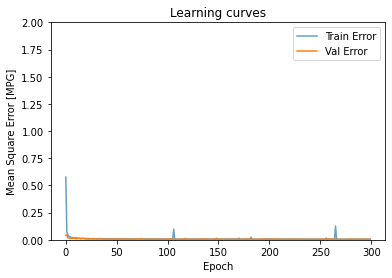

In [23]:
#Plotting learning curves
plot_history(history)

In [24]:
#Download the standard scaler
pickle.dump(scaler_2d, open('../models/Non_Gravity/noise_lvl1_with_synth_augmented/scaler_2D.pkl','wb'))
pickle.dump(scaler_3d, open('../models/Non_Gravity/noise_lvl1_with_synth_augmented/scaler_3D.pkl','wb'))

### Inference (2d --> 3d)

In [25]:
z_predicted = model.predict(X_test)

### Mean Per Joint Position Error (MPJPE)

- Per joint position error is the Euclidean distance between ground-truth and prediction for a joint
- MPJPE is the mean of per joint position error for all N joints

We will predict a Mx24 array, where M is the number of frames in our test set and 24 is 8x3 (8 keypoints and 1 coordinate per each dimension (3D))

In [26]:
#Function tat allow to split the predicted array and the ground truth array into lists of 3D coordinates per keypoint & per frame
def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

df_pred_3d = pd.DataFrame(split_3_coordinates(z_predicted))
df_gt_3d = pd.DataFrame(split_3_coordinates(y_test))
df_pred_3d = df_pred_3d.rename(columns=mapping_numbers_variables)
df_gt_3d = df_gt_3d.rename(columns=mapping_numbers_variables)

In [27]:
#Compute the euclidean distances of each 3D predicted keypoint vs the ground truth and generate a dataframe with the results.
all_distances = []
for keypoint in list(mapping_numbers_variables.values()):
    keypoint_distances = []
    for i in range(0,len(df_gt_3d[keypoint])):
        keypoint_distances.append(distance.euclidean(df_gt_3d[keypoint][i], df_pred_3d[keypoint][i]))
    all_distances.append(keypoint_distances)
df_PJPE = pd.DataFrame(all_distances).T.rename(columns=mapping_numbers_variables)

#Per joint position error dataframe euclidean distance in [mm]
(df_PJPE*1000).head(5)

,right_shoulder,right_elbow,right_wrist,left_shoulder,left_elbow,left_wrist
0,44.446830,116.191691,81.104714,122.678473,47.377834,79.689954
1,15.887286,105.518543,76.471183,86.947482,89.686108,49.209038
2,68.834525,29.332250,80.185623,66.039605,60.164092,115.143048
3,161.904733,114.528120,113.961056,243.548958,255.021072,46.361225
4,70.796966,59.293555,70.644872,116.419570,68.738591,72.535639


In [28]:
means = []
for column in list(df_PJPE.columns):
    means.append(df_PJPE[column].mean())
    
mpjpe = sum(means)/len(df_PJPE.columns)
print('The obtained MPJPE error is: '+'\033[1m'+str(mpjpe*100)+'cm')

The obtained MPJPE error is: 10.587181320799345cm


#### If you want to compute the MPJPE error for the critic keypoints 

little_PJPE = df_PJPE[['left_elbow', 'right_elbow','left_wrist','right_wrist']]
means = []
for column in list(little_PJPE.columns):
    means.append(little_PJPE[column].mean())
    
mpjpe = sum(means)/len(little_PJPE.columns)
print('The obtained MPJPE error is: '+'\033[1m'+str(mpjpe*1000)+'mm')

### Results analysis

It would be really nice have the camera model to project the obtained joints into the image frame and then compute the Mediapipe Error --> this will be done in another notebook.

#### - Boxplots per joint position Euclidean Distance

In [41]:
#df_PJPE = pd.read_csv('../../models/100k_training_0.01_normal_dropout/df_mm_PJPE.csv')

In [47]:
df_PJPE.mean()*1000

right_shoulder     9.480911
right_elbow       15.995233
right_wrist       16.666900
left_shoulder      9.620398
left_elbow        15.686295
left_wrist        17.662497
dtype: float64

In [48]:
df_PJPE.std()*1000

right_shoulder     6.382620
right_elbow        8.744790
right_wrist       10.157815
left_shoulder      6.198292
left_elbow         9.858459
left_wrist         9.724225
dtype: float64

([<matplotlib.axis.XTick at 0x21cb26a5390>,
 [Text(1, 0, 'right_shoulder'),
  Text(2, 0, 'right_elbow'),
  Text(3, 0, 'right_wrist'),
  Text(4, 0, 'left_shoulder'),
  Text(5, 0, 'left_elbow'),
  Text(6, 0, 'left_wrist')])

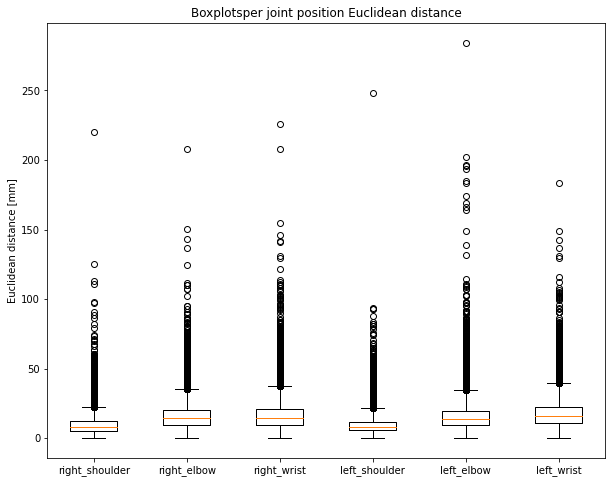

In [49]:
fig = plt.figure(figsize=(10,8))
plt.boxplot(df_PJPE*1000)
plt.title('Boxplotsper joint position Euclidean distance')
plt.ylabel('Euclidean distance [mm]')
#plt.ylim([0,80])
positions = list(mapping_numbers_variables.keys())
positions = [i+1 for i in positions]
labels = list(mapping_numbers_variables.values())
plt.xticks(positions,labels)

#### - Boxplots differences between x, y and z coordinates Predicted values vs Ground Truth

In [ ]:
diff_x = []
diff_y = []
diff_z = []
for keypoint in list(mapping_numbers_variables.values()):
    keypoint_x = []
    keypoint_y = []
    keypoint_z = []
    for i in range(0,len(df_gt_3d[keypoint])): 
        frame_info_x = []
        frame_info_y = []
        frame_info_z = []
        for j in range(0,len(df_gt_3d[keypoint][i])):
            if j == 0:
                frame_info_x.append(abs(df_gt_3d[keypoint][i][j] - df_pred_3d[keypoint][i][j]))
            if j == 1:
                frame_info_y.append(abs(df_gt_3d[keypoint][i][j] - df_pred_3d[keypoint][i][j]))
                
            if j == 2:
                frame_info_z.append(abs(df_gt_3d[keypoint][i][j] - df_pred_3d[keypoint][i][j]))
                       
        keypoint_x.append(frame_info_x[0])
        keypoint_y.append(frame_info_y[0])
        keypoint_z.append(frame_info_z[0])
        
    diff_x.append(keypoint_x)
    diff_y.append(keypoint_y)
    diff_z.append(keypoint_z)
    
df_diff_x = pd.DataFrame(diff_x).T.rename(columns=mapping_numbers_variables)
df_diff_y = pd.DataFrame(diff_y).T.rename(columns=mapping_numbers_variables)
df_diff_z = pd.DataFrame(diff_z).T.rename(columns=mapping_numbers_variables)

fig, axs = plt.subplots(1, 3,figsize=(22,12))
axs[0].boxplot(df_diff_x.values)
axs[0].grid()
axs[0].set_title('x_values')
axs[0].set_xticklabels(list(mapping_numbers_variables.values()), fontsize=6)

axs[1].boxplot(df_diff_y.values)
axs[1].grid()
axs[1].set_title('y_values')
axs[1].set_xticklabels(list(mapping_numbers_variables.values()), fontsize=6)

axs[2].boxplot(df_diff_z.values)
axs[2].grid()
axs[2].set_title('z_values')
axs[2].set_xticklabels(list(mapping_numbers_variables.values()), fontsize=6)

### Plotting 3D 

Plotting the prediciton and the ground truth of a test sample

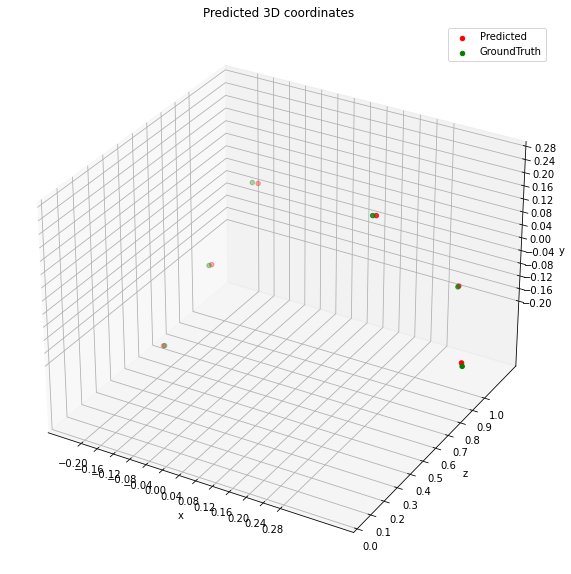

In [46]:
x_line = []
y_line = []
z_line = []

index = random.randint(0,len(X_test))

for keypoint in list(df_pred_3d.iloc[index]):
    x_line.append(keypoint[0])
    y_line.append(keypoint[1])
    z_line.append(keypoint[2])
    
    
x_line2 = []
y_line2 = []
z_line2 = []
for keypoint in list(df_gt_3d.iloc[index]):
    x_line2.append(keypoint[0])
    y_line2.append(keypoint[1])
    z_line2.append(keypoint[2])
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


ax.scatter(x_line, z_line,y_line,c='r',label='Predicted')
ax.scatter(x_line2, z_line2,y_line2,c='g',label='GroundTruth')
ax.set_xticks(np.arange(-0.2,0.3,0.04))
ax.set_xlabel('x')
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_ylabel('z')
ax.set_zticks(np.arange(-0.2,0.3,0.04))
ax.set_zlabel('y')
ax.set_title('Predicted 3D coordinates')
ax.legend()


### Exporting neural network

In [38]:
model.save('../../models/Experiment_12_correction/model.h5')

In [39]:
#Download the standard scaler
pickle.dump(scaler1, open('../../models/Experiment_12_correction/scaler.pkl','wb'))